# AMLO Exploratory Data Analysis

In [14]:
import re
import os
import pandas as pd
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from amlo_parser import AMLOParser
from training_set import TrainingSet

#### CONSTANTS

In [15]:
PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/text_files/"
LABELED_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/amlo_labeling.xlsx"

### Pipeline

### Classification Task

In [16]:
all_files = os.listdir(PATH)

training_set = TrainingSet(remove_stopwords=True)
training_set.create_training_set()

 21%|██▏       | 266/1246 [00:00<00:00, 2531.07it/s]

Conference 20181207 is not agressive
Conference 20190102 is not agressive
Conference 20190111 is not agressive
Conference 20190227 is not agressive
Conference 20200128 is not agressive
Conference 20210510 is not agressive


100%|██████████| 1246/1246 [00:00<00:00, 3618.92it/s]

Conference 20221125 is not agressive


### REGRESSION TASK

In [17]:
import os
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

In [18]:
def create_regression_training_df(folder_path, dialogues_path):
    """
    Creates a DataFrame with the training data for the classification model
    """

    # Initialize an empty list to store data
    data = []

    # Iterate through each file in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            # Determine the label based on the file name
            label = 0 if "non" in file else 1
            id = int(re.findall(r"\d+", file)[0])
            # Read the text file
            with open(os.path.join(folder_path, file), "r", encoding="utf-8") as f:
                text = f.read()
            if label == 1:
                # Get text from president's dialogues
                with open(
                    os.path.join(dialogues_path, f"{id}_president_dialogues.txt"),
                    "r",
                    encoding="utf-8",
                ) as f:
                    dialogues = f.read()

                # Ratio of agressive phrases
                length_agressive = len(text.split())
                length_total = len(dialogues.split())

                ratio = length_agressive / length_total

                data.append({"id": id, "text": text, "score": ratio})

            else:
                continue

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)

    return df

In [19]:
def train_xgboost(df):
    """
    Trains an XGBoost model to predict
    the score of agressivity
    """

    # Import the XGBoost library
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)

    # Fit and transform the 'text' column
    X = tfidf_vectorizer.fit_transform(df["text"])

    # Assuming 'label' is your target variable
    y = df["score"]

    # Assuming `X` is your matrix of embeddings and `y` is your vector of normalized aggressivity scores
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Create the DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define the parameters
    param = {
        "max_depth": 8,
        "eta": 0.15,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
    }

    # Train the model
    num_round = 250
    bst = xgb.train(param, dtrain, num_round)

    # Make predictions
    y_pred = bst.predict(dtest)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

    return bst, tfidf_vectorizer

In [20]:
def create_unseen_df(training_set, df):
    # Now, let us do it for the entire dataset
    data = []

    labeled_ids = df["id"].values

    # Iterate through each file in the folder
    for file in os.listdir(training_set.DIALOGUES_PATH):
        if file.endswith(".txt"):
            # Determine the label based on the file name
            conference_id = int(re.findall(r"\d+", file)[0])

            if conference_id not in labeled_ids:
                # Read the text file
                with open(
                    os.path.join(training_set.DIALOGUES_PATH, file),
                    "r",
                    encoding="utf-8",
                ) as f:
                    text = f.read()
                    data.append({"id": conference_id, "text": text})

    unseen_df = pd.DataFrame(data)

    return unseen_df

In [21]:
def predict_unseen_data(model, unseen_df, tfidf_vectorizer, regression=False):
    """
    Predicts the labels for the unseen data
    """
    # Fit and transform the 'text' column
    X_unseen = tfidf_vectorizer.fit_transform(unseen_df["text"])

    # Make predictions on the unseen data
    y_unseen = model.predict(X_unseen)

    # Add the predictions to the DataFrame
    if regression:
        unseen_df["score"] = y_unseen
    else:
        unseen_df["label"] = y_unseen

    return unseen_df

In [22]:
def predict_xgboost(model, unseen_df, tfidf_vectorizer):
    """
    Predicts the labels for the unseen data
    """
    # Fit and transform the 'text' column
    X_unseen = tfidf_vectorizer.fit_transform(unseen_df["text"])

    # Create the DMatrix
    d_unseen = xgb.DMatrix(X_unseen)

    # Make predictions
    y_unseen = model.predict(d_unseen)

    # Add the predictions to the DataFrame
    unseen_df["score"] = y_unseen

    return unseen_df

#### MODELING PIPELINE

In [23]:
# Specify the path to your training data folder
folder_path = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/training_data/"

In [24]:
# Train the XGBoost model

training_df = create_regression_training_df(
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/training_data/",
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/presidents_dialogues/",
)

xgboost_model, tfidf_vectorizer = train_xgboost(training_df)

# Create the unseen data DataFrame
unseen_df = create_unseen_df(training_set)

# Predict the labels for the unseen data
results_df = predict_xgboost(xgboost_model, unseen_df, tfidf_vectorizer)

# Concat the results and the training data

complete_df = pd.concat([training_df, results_df], ignore_index=True)

scaler = MinMaxScaler()

# Normalize the score
scores = np.array(complete_df["score"]).reshape(-1, 1)

scaler.fit(scores)

complete_df["score"] = scaler.transform(scores)

complete_df.head()

# Save the results to a CSV file

# Add a column with the length of the text

complete_df["num_words"] = complete_df["text"].apply(lambda x: len(x.split()))

complete_df.to_csv(
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/xgb_agressivity_scores.csv", index=False
)

Mean Squared Error: 0.0020967836410646984
R^2 Score: 0.04109913896256623


In [25]:
# Remove text column
complete_df = complete_df.drop("text", axis=1)

# Save the results to a CSV file
complete_df.to_csv(
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/xgb_agressivity_scores_no_words.csv",
    index=False,
)

Text(0.5, 1.0, 'Distribution of Aggressivity Scores')

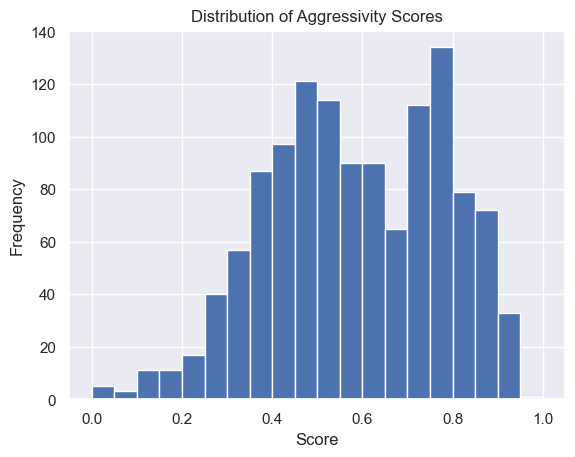

In [26]:
# Plot histogram of the scores

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.hist(complete_df["score"], bins=20)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Aggressivity Scores")

### Possible models to use:

Summarization:

https://huggingface.co/mrm8488/bert2bert_shared-spanish-finetuned-summarization


Sentiment Analysis:

https://huggingface.co/finiteautomata/beto-sentiment-analysis


Emotion Analysis:

https://huggingface.co/finiteautomata/beto-emotion-analysis
